# VGG-16 on STL-09 — Step-by-step Image Classification Pipeline

**Overall objective:** Train **VGG-16** on **STL-10** (10 classes) for image classification, monitor train/test performance, and visualize intermediate feature maps + Grad-CAM to understand what the network learns.

---

## End-to-end pipeline (high level)

1. Set experiment configuration  
2. Install/import libraries  
3. Device + reproducibility  
4. Define transforms (ImageNet stats)  
5. Download/load STL-10  
6. Create DataLoaders  
7. Visualize batch  
8. Build VGG-16 (10 classes)  
9. Architecture summary (shapes/params)  
10. Loss/optimizer/scheduler  
11. Train for 10–20 epochs + checkpoints  
12. Plot learning curves  
13. Evaluate best checkpoint + metrics + confusion matrix  
14. Capture intermediate activations (hooks)  
15. Visualize feature maps  
16. Visualize Conv1 filters  
17. Grad-CAM (last conv)  
18. Inference utilities  

> **Note:** VGG-16 is heavier than AlexNet. If you get GPU out-of-memory, reduce `batch_size` in Step 1 (e.g., 16 or 8).


## Step 1 — Experiment configuration *(Make runs reproducible)*

In [1]:

from pathlib import Path

CFG = {
    "seed": 42,

    # Data
    "dataset_name": "STL10",
    "num_classes": 10,
    "img_size": 224,
    "batch_size": 32,       # VGG-16 is heavier; lower if OOM
    "num_workers": 4,       # set 0 on Windows if DataLoader issues

    # Training
    "epochs": 20,           # set 10 or 20
    "lr": 1e-3,             # we'll use AdamW by default for stability
    "weight_decay": 1e-4,

    # Runtime
    "device": "cuda",       # auto-fallback to cpu
    "amp": True,            # mixed precision if CUDA available

    # Output
    "work_dir": "./vgg16_stl10_runs",
    "run_name": "vgg16_stl10_v1",
}

run_dir = Path(CFG["work_dir"]) / CFG["run_name"]
ckpt_dir = run_dir / "checkpoints"
viz_dir  = run_dir / "viz"
data_root = run_dir / "data"

for d in [run_dir, ckpt_dir, viz_dir, data_root]:
    d.mkdir(parents=True, exist_ok=True)

print("✅ Config loaded")
print("Run dir:", run_dir.resolve())
print("Checkpoints:", ckpt_dir.resolve())
print("Visualizations:", viz_dir.resolve())
print("Data root:", data_root.resolve())
print("Key settings:", f"img_size={CFG['img_size']}, batch_size={CFG['batch_size']}, epochs={CFG['epochs']}, lr={CFG['lr']}")


✅ Config loaded
Run dir: C:\Users\Dr.PVVK\dna_2026\vgg16_stl10_runs\vgg16_stl10_v1
Checkpoints: C:\Users\Dr.PVVK\dna_2026\vgg16_stl10_runs\vgg16_stl10_v1\checkpoints
Visualizations: C:\Users\Dr.PVVK\dna_2026\vgg16_stl10_runs\vgg16_stl10_v1\viz
Data root: C:\Users\Dr.PVVK\dna_2026\vgg16_stl10_runs\vgg16_stl10_v1\data
Key settings: img_size=224, batch_size=32, epochs=20, lr=0.001


## Step 2 — Install/import libraries *(Enable full pipeline)*

In [2]:

# If something is missing, install it (safe to re-run)

import importlib, sys, subprocess

def ensure(pkg, import_name=None):
    name = import_name or pkg
    try:
        importlib.import_module(name)
    except Exception:
        print(f"Installing: {pkg}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Core libs (PyTorch/torchvision should already exist in most ML envs)
ensure("numpy")
ensure("matplotlib")
ensure("pandas")
ensure("scikit-learn", "sklearn")

# Imports
import os, random, time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

print("✅ Imports successful")
print("PyTorch:", torch.__version__)
import torchvision
print("TorchVision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


✅ Imports successful
PyTorch: 2.4.0+cu118
TorchVision: 0.19.0+cu118
CUDA available: True
GPU: NVIDIA GeForce GTX 1070


## Step 3 — Device + seed *(Ensure deterministic behavior)*

In [3]:

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG["seed"])

if CFG["device"] == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

use_amp = bool(CFG["amp"] and device.type == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

print("✅ Seed set:", CFG["seed"])
print("✅ Device:", device)
print("✅ AMP:", use_amp)


✅ Seed set: 42
✅ Device: cuda
✅ AMP: True


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_40336\1324929735.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


## Step 4 — Define transforms *(Match VGG/ImageNet input stats)*

In [4]:

from PIL import Image

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(CFG["img_size"]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(CFG["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

def denorm(img_t: torch.Tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    mean_t = torch.tensor(mean).view(3,1,1)
    std_t  = torch.tensor(std).view(3,1,1)
    x = img_t.detach().cpu() * std_t + mean_t
    return x.clamp(0, 1)

# Sanity check
dummy = (np.random.rand(96, 96, 3) * 255).astype(np.uint8)
dummy_pil = Image.fromarray(dummy)
x_train = train_tfms(dummy_pil)
x_test  = test_tfms(dummy_pil)

print("✅ Transforms ready")
print("Train:", tuple(x_train.shape), "Test:", tuple(x_test.shape))


✅ Transforms ready
Train: (3, 224, 224) Test: (3, 224, 224)


## Step 5 — Download/load STL-10 *(Create train/test datasets)*

In [5]:

train_ds = datasets.STL10(root=str(data_root), split="train", download=True, transform=train_tfms)
test_ds  = datasets.STL10(root=str(data_root), split="test",  download=True, transform=test_tfms)

print("✅ STL-10 loaded")
print("Train size:", len(train_ds))
print("Test  size:", len(test_ds))
print("Classes:", train_ds.classes)

x0, y0 = train_ds[0]
print("Sample x0:", tuple(x0.shape), "y0:", int(y0), "->", train_ds.classes[int(y0)])


100%|████████████████████████████████████████████████████████████| 2640397119/2640397119 [03:46<00:00, 11663630.63it/s]


Extracting vgg16_stl10_runs\vgg16_stl10_v1\data\stl10_binary.tar.gz to vgg16_stl10_runs\vgg16_stl10_v1\data
Files already downloaded and verified
✅ STL-10 loaded
Train size: 5000
Test  size: 8000
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Sample x0: (3, 224, 224) y0: 1 -> bird


## Step 6 — Create DataLoaders *(Batch and shuffle samples)*

In [6]:

nw = 0 if os.name == "nt" else int(CFG["num_workers"])
pin = (device.type == "cuda")

train_loader = DataLoader(
    train_ds, batch_size=CFG["batch_size"], shuffle=True,
    num_workers=nw, pin_memory=pin, drop_last=True,
    persistent_workers=(nw > 0), prefetch_factor=2 if nw > 0 else None
)

test_loader = DataLoader(
    test_ds, batch_size=CFG["batch_size"], shuffle=False,
    num_workers=nw, pin_memory=pin, drop_last=False,
    persistent_workers=(nw > 0), prefetch_factor=2 if nw > 0 else None
)

xb, yb = next(iter(train_loader))
print("✅ DataLoaders ready")
print("num_workers:", nw, "| pin_memory:", pin)
print("Batch xb:", tuple(xb.shape), "yb:", tuple(yb.shape))


✅ DataLoaders ready
num_workers: 0 | pin_memory: True
Batch xb: (32, 3, 224, 224) yb: (32,)


## Step 7 — Visualize a batch *(Verify images and labels)*

Displayed labels: ['airplane', 'ship', 'deer', 'horse', 'truck', 'bird', 'truck', 'airplane', 'bird', 'monkey', 'ship', 'car', 'airplane', 'ship', 'ship', 'car']


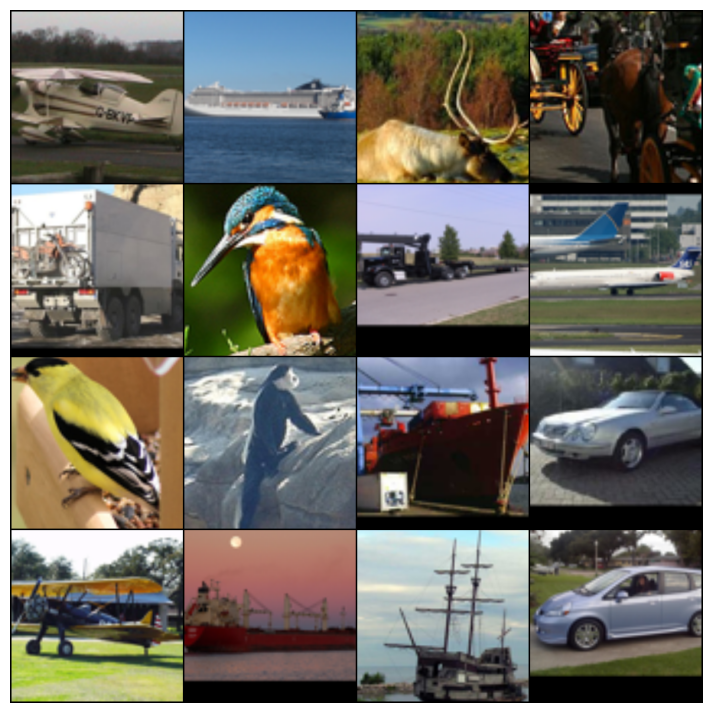

In [7]:

xb, yb = next(iter(train_loader))
n_show = min(16, xb.size(0))

imgs = torch.stack([denorm(xb[i]) for i in range(n_show)], dim=0)
grid = make_grid(imgs, nrow=4)

plt.figure(figsize=(9, 9))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")

label_names = [train_ds.classes[int(y)] for y in yb[:n_show]]
print("Displayed labels:", label_names)
plt.show()


## Step 8 — Build VGG-16 *(Replace AlexNet with VGG-16)*

In [8]:

# VGG-16 (no pretrained weights; train from scratch)
# If you want pretrained weights later, you can set weights=models.VGG16_Weights.IMAGENET1K_V1

model = models.vgg16(weights=None)

# Replace classifier output to 10 classes (STL-10)
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, CFG["num_classes"])

model = model.to(device)

# Quick sanity forward
model.eval()
xb, yb = next(iter(train_loader))
xb = xb.to(device, non_blocking=True)
with torch.no_grad():
    logits = model(xb)

print("✅ VGG-16 ready")
print("Logits shape:", tuple(logits.shape))
print("Trainable params:", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("Final layer:", model.classifier[-1])


✅ VGG-16 ready
Logits shape: (32, 10)
Trainable params: 134,301,514
Final layer: Linear(in_features=4096, out_features=10, bias=True)


## Step 9 — Architecture summary *(Input/output shapes + params)*

In [9]:

# Programmatic summary table using forward hooks on leaf modules

import pandas as pd
import torch.nn as nn

model_arch = model.to("cpu").eval()

records = []
handles = []

def is_leaf(m):
    return len(list(m.children())) == 0

def hook_fn(name):
    def _hook(m, inp, out):
        in_shape = tuple(inp[0].shape) if isinstance(inp, (tuple, list)) and hasattr(inp[0], "shape") else None
        out_shape = tuple(out.shape) if hasattr(out, "shape") else None
        params = sum(p.numel() for p in m.parameters() if p.requires_grad)

        rec = {
            "name": name,
            "type": m.__class__.__name__,
            "in_shape": in_shape,
            "out_shape": out_shape,
            "filters/units": "",
            "kernel": "",
            "stride": "",
            "padding": "",
            "activation": "",
            "trainable_params": params,
        }

        if isinstance(m, nn.Conv2d):
            rec["filters/units"] = m.out_channels
            rec["kernel"] = tuple(m.kernel_size)
            rec["stride"] = tuple(m.stride)
            rec["padding"] = tuple(m.padding)
        elif isinstance(m, nn.Linear):
            rec["filters/units"] = m.out_features
        elif isinstance(m, nn.MaxPool2d):
            rec["kernel"] = m.kernel_size
            rec["stride"] = m.stride
            rec["padding"] = m.padding
        elif isinstance(m, nn.AdaptiveAvgPool2d):
            rec["kernel"] = f"out={m.output_size}"
        elif isinstance(m, nn.Dropout):
            rec["kernel"] = f"p={m.p}"

        records.append(rec)
    return _hook

for name, m in model_arch.named_modules():
    if is_leaf(m):
        handles.append(m.register_forward_hook(hook_fn(name)))

x = torch.zeros(1, 3, CFG["img_size"], CFG["img_size"])
with torch.no_grad():
    _ = model_arch(x)

for h in handles:
    h.remove()

# Merge ReLU activations into previous row
merged = []
for r in records:
    if r["type"] == "ReLU":
        if merged:
            merged[-1]["activation"] = "ReLU"
        continue
    merged.append(r)

df = pd.DataFrame(merged)

def shape_chw(s):
    if s is None: return ""
    s = tuple(s)
    if len(s) == 4: return f"{s[1]}x{s[2]}x{s[3]}"
    if len(s) == 2: return str(s[1])
    return str(s)

df["in"] = df["in_shape"].apply(shape_chw)
df["out"] = df["out_shape"].apply(shape_chw)

show = df[[
    "name", "type", "in", "out",
    "filters/units", "kernel", "stride", "padding",
    "activation", "trainable_params"
]].copy()
show.insert(0, "#", range(1, len(show) + 1))

print("✅ VGG-16 summary (first 40 rows)")
print("Total trainable params:", f"{int(show['trainable_params'].sum()):,}")

show.head(40)


✅ VGG-16 summary (first 40 rows)
Total trainable params: 134,301,514


#          name               type           in          out  \
0    1    features.0             Conv2d    3x224x224   64x224x224   
1    2    features.2             Conv2d   64x224x224   64x224x224   
2    3    features.4          MaxPool2d   64x224x224   64x112x112   
3    4    features.5             Conv2d   64x112x112  128x112x112   
4    5    features.7             Conv2d  128x112x112  128x112x112   
5    6    features.9          MaxPool2d  128x112x112    128x56x56   
6    7   features.10             Conv2d    128x56x56    256x56x56   
7    8   features.12             Conv2d    256x56x56    256x56x56   
8    9   features.14             Conv2d    256x56x56    256x56x56   
9   10   features.16          MaxPool2d    256x56x56    256x28x28   
10  11   features.17             Conv2d    256x28x28    512x28x28   
11  12   features.19             Conv2d    512x28x28    512x28x28   
12  13   features.21             Conv2d    512x28x28    512x28x28   
13  14   features.23          MaxPool2d    512x28x28    512x14x14   
14  15   features.24             Conv2d    512x14x14    512x14x14   
15  16   features.26             Conv2d    512x14x14    512x14x14   
16  17   features.28             Conv2d    512x14x14    512x14x14   
17  18   features.30          MaxPool2d    512x14x14      512x7x7   
18  19       avgpool  AdaptiveAvgPool2d      512x7x7      512x7x7   
19  20  classifier.0             Linear        25088         4096   
20  21  classifier.2            Dropout         4096         4096   
21  22  classifier.3             Linear         4096         4096   
22  23  classifier.5            Dropout         4096         4096   
23  24  classifier.6             Linear         4096           10   

   filters/units      kernel  stride padding activation  trainable_params  
0             64      (3, 3)  (1, 1)  (1, 1)       ReLU              1792  
1             64      (3, 3)  (1, 1)  (1, 1)       ReLU             36928  
2                          2       2       0                            0  
3            128      (3, 3)  (1, 1)  (1, 1)       ReLU             73856  
4            128      (3, 3)  (1, 1)  (1, 1)       ReLU            147584  
5                          2       2       0                            0  
6            256      (3, 3)  (1, 1)  (1, 1)       ReLU            295168  
7            256      (3, 3)  (1, 1)  (1, 1)       ReLU            590080  
8            256      (3, 3)  (1, 1)  (1, 1)       ReLU            590080  
9                          2       2       0                            0  
10           512      (3, 3)  (1, 1)  (1, 1)       ReLU           1180160  
11           512      (3, 3)  (1, 1)  (1, 1)       ReLU           2359808  
12           512      (3, 3)  (1, 1)  (1, 1)       ReLU           2359808  
13                         2       2       0                            0  
14           512      (3, 3)  (1, 1)  (1, 1)       ReLU           2359808  
15           512      (3, 3)  (1, 1)  (1, 1)       ReLU           2359808  
16           512      (3, 3)  (1, 1)  (1, 1)       ReLU           2359808  
17                         2       2       0                            0  
18                out=(7, 7)                                            0  
19          4096                                   ReLU         102764544  
20                     p=0.5                                            0  
21          4096                                   ReLU          16781312  
22                     p=0.5                                            0  
23            10                                                    40970

In [10]:

# Move model back to training device
model = model.to(device)


## Step 10 — Loss/optimizer/scheduler *(Define training objective)*

In [11]:

criterion = nn.CrossEntropyLoss()

# AdamW is stable for training VGG-16 from scratch on smaller datasets
optimizer = optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

# Cosine schedule over total epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG["epochs"])

print("✅ Training components ready")
print("Loss: CrossEntropyLoss")
print("Optimizer: AdamW", optimizer.param_groups[0]["lr"])


✅ Training components ready
Loss: CrossEntropyLoss
Optimizer: AdamW 0.001


## Step 11 — Train for 10–20 epochs *(Train + test + checkpoints)*

In [12]:

import time
import torch

def save_checkpoint(path, **payload):
    torch.save(payload, str(path))
    print(f"✅ Saved: {path}")

def train_one_epoch(model, loader, optimizer, criterion, device, use_amp=False, scaler=None, log_every=20):
    model.train()
    if scaler is None:
        scaler = torch.cuda.amp.GradScaler(enabled=False)

    t0 = time.time()
    total_loss, total_correct, total_seen = 0.0, 0, 0

    for step, (xb, yb) in enumerate(loader, start=1):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(xb)
            loss = criterion(logits, yb)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = xb.size(0)
        total_seen += bs
        total_loss += loss.detach().item() * bs
        total_correct += (logits.argmax(1) == yb).sum().item()

        if step == 1 or step % log_every == 0 or step == len(loader):
            avg_loss = total_loss / total_seen
            avg_acc = 100.0 * total_correct / total_seen
            lr = optimizer.param_groups[0]["lr"]
            print(f"  step {step:4d}/{len(loader)} | lr {lr:.6f} | loss {avg_loss:.4f} | acc {avg_acc:.2f}%")

    return (total_loss / total_seen), (100.0 * total_correct / total_seen), (time.time() - t0)

@torch.no_grad()
def evaluate(model, loader, criterion, device, use_amp=False):
    model.eval()
    t0 = time.time()
    total_loss, total_correct, total_seen = 0.0, 0, 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(xb)
            loss = criterion(logits, yb)

        bs = xb.size(0)
        total_seen += bs
        total_loss += loss.detach().item() * bs
        total_correct += (logits.argmax(1) == yb).sum().item()

    return (total_loss / total_seen), (100.0 * total_correct / total_seen), (time.time() - t0)

history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": [], "lr": []}
best_test_acc = -1.0

EPOCHS = int(CFG["epochs"])
print("✅ Starting training for", EPOCHS, "epochs")

for epoch in range(1, EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")
    tr_loss, tr_acc, tr_time = train_one_epoch(
        model, train_loader, optimizer, criterion, device,
        use_amp=use_amp, scaler=scaler, log_every=20
    )

    te_loss, te_acc, te_time = evaluate(
        model, test_loader, criterion, device, use_amp=use_amp
    )

    scheduler.step()
    lr_now = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["test_loss"].append(te_loss)
    history["test_acc"].append(te_acc)
    history["lr"].append(lr_now)

    print(f"Epoch {epoch:02d} | train: loss {tr_loss:.4f}, acc {tr_acc:.2f}% ({tr_time:.1f}s) "
          f"| test: loss {te_loss:.4f}, acc {te_acc:.2f}% ({te_time:.1f}s) | lr {lr_now:.6f}")

    # Save latest
    latest_path = ckpt_dir / "vgg16_stl10_latest.pt"
    save_checkpoint(
        latest_path,
        epoch=epoch,
        cfg=CFG,
        model_state=model.state_dict(),
        optimizer_state=optimizer.state_dict(),
        scheduler_state=scheduler.state_dict(),
        best_test_acc=best_test_acc,
        history=history
    )

    # Save best
    if te_acc > best_test_acc:
        best_test_acc = float(te_acc)
        best_path = ckpt_dir / "vgg16_stl10_best.pt"
        save_checkpoint(
            best_path,
            epoch=epoch,
            cfg=CFG,
            model_state=model.state_dict(),
            optimizer_state=optimizer.state_dict(),
            scheduler_state=scheduler.state_dict(),
            best_test_acc=best_test_acc,
            history=history
        )
        print(f"🏆 New best test acc: {best_test_acc:.2f}%")

print("\n✅ Training complete")
print("Best test acc:", best_test_acc)


✅ Starting training for 20 epochs

===== Epoch 1/20 =====


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_40336\4117301664.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


  step    1/156 | lr 0.001000 | loss 2.2905 | acc 15.62%
  step   20/156 | lr 0.001000 | loss 367.6424 | acc 9.38%
  step   40/156 | lr 0.001000 | loss 184.9742 | acc 9.14%
  step   60/156 | lr 0.001000 | loss 124.0845 | acc 8.39%
  step   80/156 | lr 0.001000 | loss 93.6387 | acc 8.87%
  step  100/156 | lr 0.001000 | loss 75.3717 | acc 9.12%
  step  120/156 | lr 0.001000 | loss 63.1937 | acc 9.24%
  step  140/156 | lr 0.001000 | loss 54.4951 | acc 9.13%
  step  156/156 | lr 0.001000 | loss 49.1451 | acc 9.11%


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_40336\4117301664.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 01 | train: loss 49.1451, acc 9.11% (81.3s) | test: loss 2.3041, acc 10.00% (46.8s) | lr 0.000994
✅ Saved: vgg16_stl10_runs\vgg16_stl10_v1\checkpoints\vgg16_stl10_latest.pt
✅ Saved: vgg16_stl10_runs\vgg16_stl10_v1\checkpoints\vgg16_stl10_best.pt
🏆 New best test acc: 10.00%

===== Epoch 2/20 =====
  step    1/156 | lr 0.000994 | loss 2.2982 | acc 25.00%
  step   20/156 | lr 0.000994 | loss 2.3191 | acc 10.31%
  step   40/156 | lr 0.000994 | loss 2.3105 | acc 10.70%
  step   60/156 | lr 0.000994 | loss 2.3079 | acc 11.25%
  step   80/156 | lr 0.000994 | loss 2.3079 | acc 10.47%
  step  100/156 | lr 0.000994 | loss 2.3069 | acc 10.53%
  step  120/156 | lr 0.000994 | loss 2.3062 | acc 10.49%
  step  140/156 | lr 0.000994 | loss 2.3059 | acc 10.31%
  step  156/156 | lr 0.000994 | loss 2.3056 | acc 10.24%
Epoch 02 | train: loss 2.3056, acc 10.24% (80.6s) | test: loss 2.3027, acc 10.00% (50.6s) | lr 0.000976
✅ Saved: vgg16_stl10_runs\vgg16_stl10_v1\checkpoints\vgg16_stl10_latest.pt

===

## Step 12 — Plot learning curves *(Train/test loss & accuracy)*

Lengths: train_loss 20 test_loss 20 train_acc 20 test_acc 20 lr 20


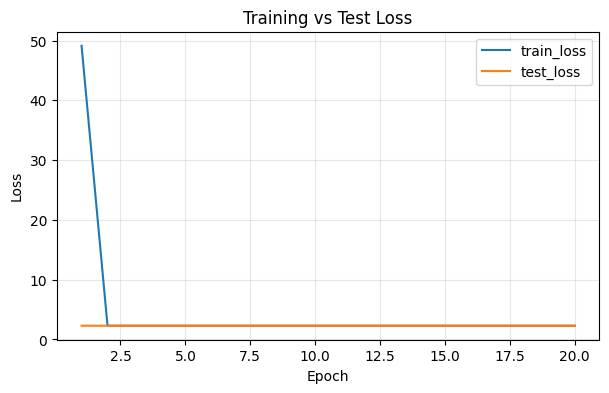

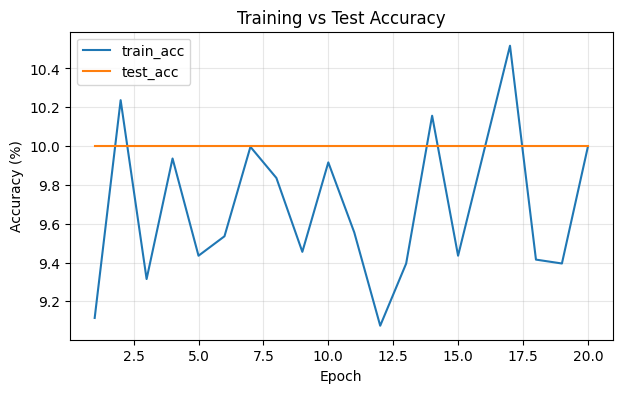

In [13]:

import matplotlib.pyplot as plt

def _len(x): 
    return len(x) if x is not None else 0

print("Lengths:",
      "train_loss", _len(history.get("train_loss")),
      "test_loss",  _len(history.get("test_loss")),
      "train_acc",  _len(history.get("train_acc")),
      "test_acc",   _len(history.get("test_acc")),
      "lr",         _len(history.get("lr")))

# Loss
plt.figure(figsize=(7,4))
x_tr = range(1, len(history["train_loss"]) + 1)
plt.plot(list(x_tr), history["train_loss"], label="train_loss")
x_te = range(1, len(history["test_loss"]) + 1)
plt.plot(list(x_te), history["test_loss"], label="test_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Test Loss")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# Accuracy
plt.figure(figsize=(7,4))
x_tr = range(1, len(history["train_acc"]) + 1)
plt.plot(list(x_tr), history["train_acc"], label="train_acc")
x_te = range(1, len(history["test_acc"]) + 1)
plt.plot(list(x_te), history["test_acc"], label="test_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Training vs Test Accuracy")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


## Step 13 — Evaluate best checkpoint *(Metrics + confusion matrix)*

C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_40336\3033896644.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(best_path), map_location="cpu")


✅ Loaded best checkpoint
Epoch: 1
best_test_acc (saved): 10.0


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_40336\3033896644.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):



=== Test Metrics (Best VGG-16) ===
Accuracy : 10.00%
Precision (macro): 1.00%
Recall    (macro): 10.00%
F1-score  (macro): 1.82%

=== Per-class Report ===
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00       800
        bird       0.10      1.00      0.18       800
         car       0.00      0.00      0.00       800
         cat       0.00      0.00      0.00       800
        deer       0.00      0.00      0.00       800
         dog       0.00      0.00      0.00       800
       horse       0.00      0.00      0.00       800
      monkey       0.00      0.00      0.00       800
        ship       0.00      0.00      0.00       800
       truck       0.00      0.00      0.00       800

    accuracy                           0.10      8000
   macro avg       0.01      0.10      0.02      8000
weighted avg       0.01      0.10      0.02      8000



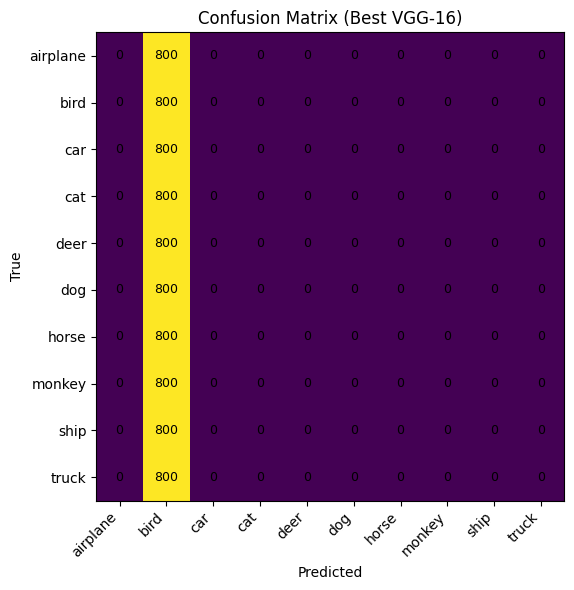

In [14]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

best_path = ckpt_dir / "vgg16_stl10_best.pt"
assert best_path.exists(), f"Best checkpoint not found: {best_path}"

ckpt = torch.load(str(best_path), map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model = model.to(device).eval()

print("✅ Loaded best checkpoint")
print("Epoch:", ckpt.get("epoch", "N/A"))
print("best_test_acc (saved):", ckpt.get("best_test_acc", "N/A"))

@torch.no_grad()
def eval_collect_preds(model, loader, device, use_amp=False):
    all_preds, all_y = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(xb)
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_y.append(yb.numpy())
    return np.concatenate(all_y), np.concatenate(all_preds)

y_true, y_pred = eval_collect_preds(model, test_loader, device=device, use_amp=use_amp)

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)

print("\n=== Test Metrics (Best VGG-16) ===")
print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision (macro): {prec*100:.2f}%")
print(f"Recall    (macro): {rec*100:.2f}%")
print(f"F1-score  (macro): {f1*100:.2f}%")

class_names = train_ds.classes
print("\n=== Per-class Report ===")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=list(range(CFG["num_classes"])))

plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.title("Confusion Matrix (Best VGG-16)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(CFG["num_classes"]), class_names, rotation=45, ha="right")
plt.yticks(range(CFG["num_classes"]), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()


## Step 14 — Capture intermediate activations *(Hooks for feature maps)*

In [15]:

import torch
import torch.nn as nn

# Pick 3 conv layers: first, middle, last conv from VGG features
conv_layers = [(i, m) for i, m in enumerate(model.features) if isinstance(m, nn.Conv2d)]
print("Total conv layers:", len(conv_layers))
print("First conv idx:", conv_layers[0][0], "| Last conv idx:", conv_layers[-1][0])

pick = [conv_layers[0][0], conv_layers[len(conv_layers)//2][0], conv_layers[-1][0]]
layer_map = {f"conv_{i}": model.features[i] for i in pick}

acts = {}
handles = []

def make_hook(name):
    def _hook(module, inp, out):
        acts[name] = out.detach().cpu()
    return _hook

for name, layer in layer_map.items():
    handles.append(layer.register_forward_hook(make_hook(name)))

print("✅ Hooks registered for:", list(layer_map.keys()))

# Run on a chosen test image
idx = 0
x_img, y_lbl = test_ds[idx]
x_in = x_img.unsqueeze(0).to(device)

model.eval()
with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):
    logits = model(x_in)
    pred = int(logits.argmax(dim=1).detach().cpu())

print(f"✅ Forward pass done for test_ds[{idx}]")
print("True:", int(y_lbl), "->", class_names[int(y_lbl)])
print("Pred:", pred, "->", class_names[pred])

for k in acts:
    print(f"{k} :", tuple(acts[k].shape))


Total conv layers: 13
First conv idx: 0 | Last conv idx: 28
✅ Hooks registered for: ['conv_0', 'conv_14', 'conv_28']
✅ Forward pass done for test_ds[0]
True: 6 -> horse
Pred: 1 -> bird
conv_0 : (1, 64, 224, 224)
conv_14 : (1, 256, 56, 56)
conv_28 : (1, 512, 14, 14)


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_40336\2928156110.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):


## Step 15 — Visualize feature maps *(Grid + top-activated channels)*

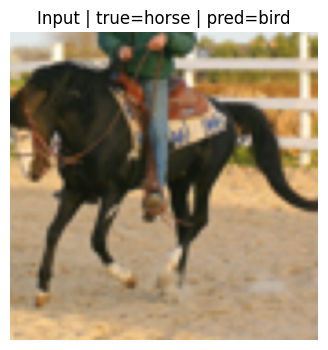

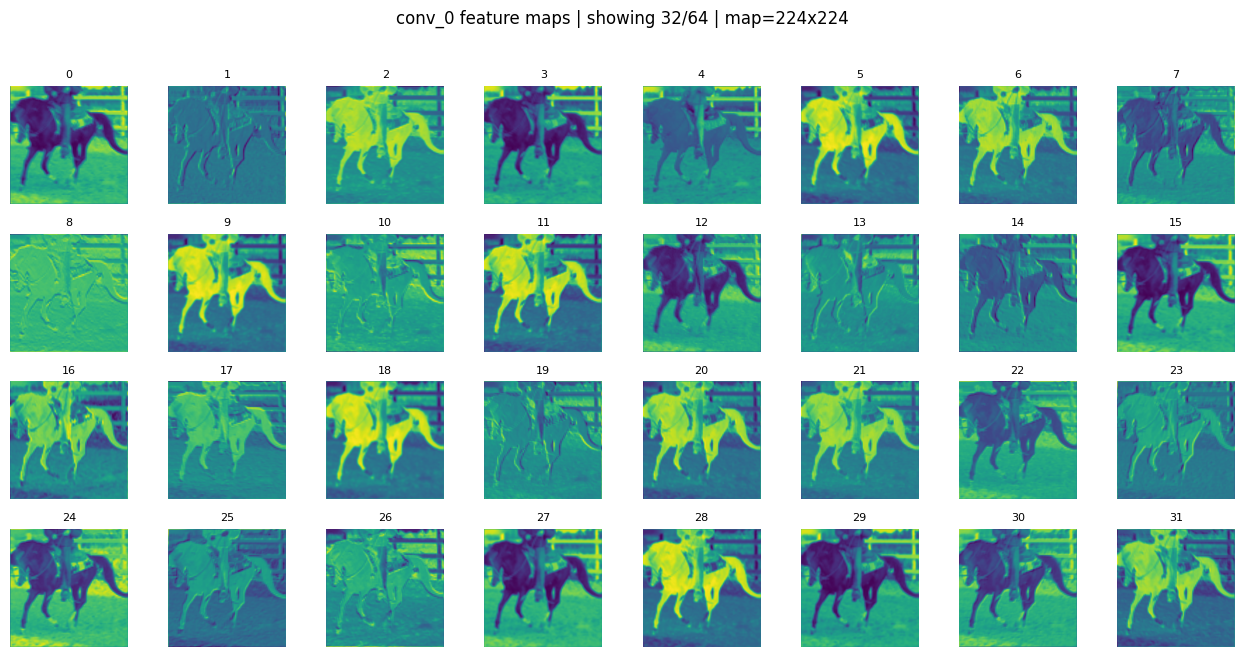

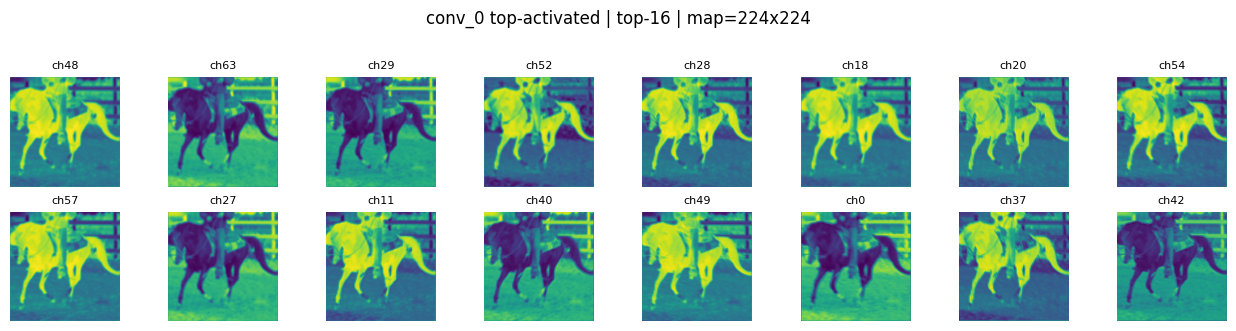

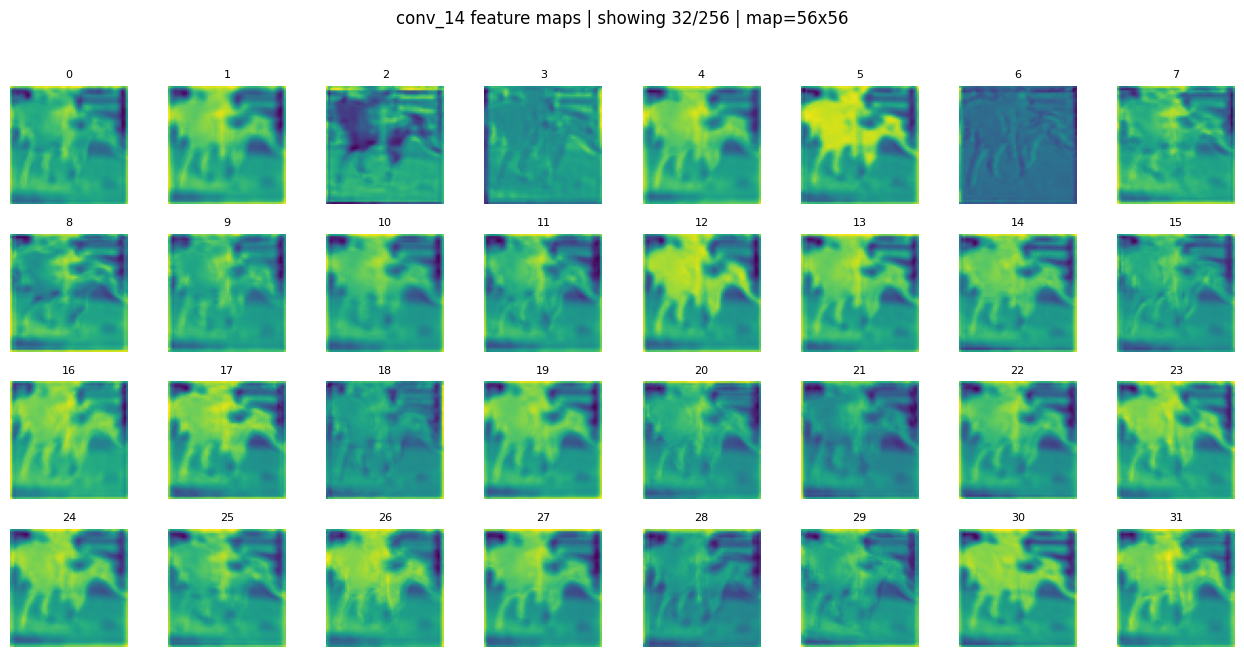

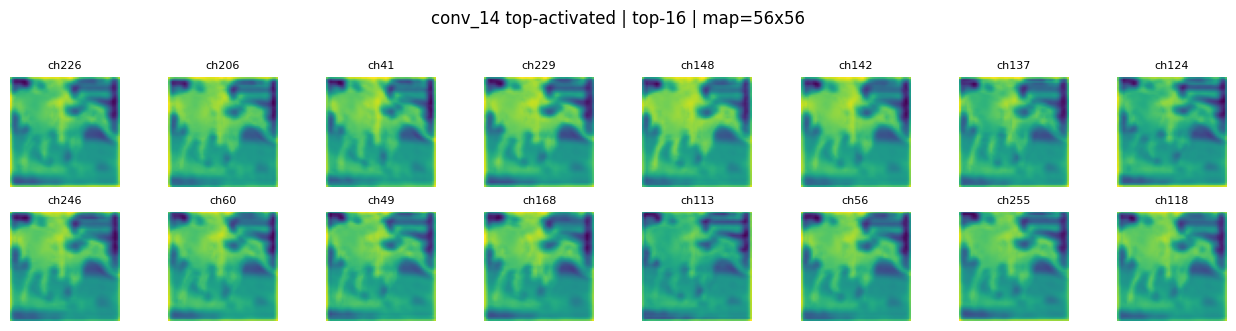

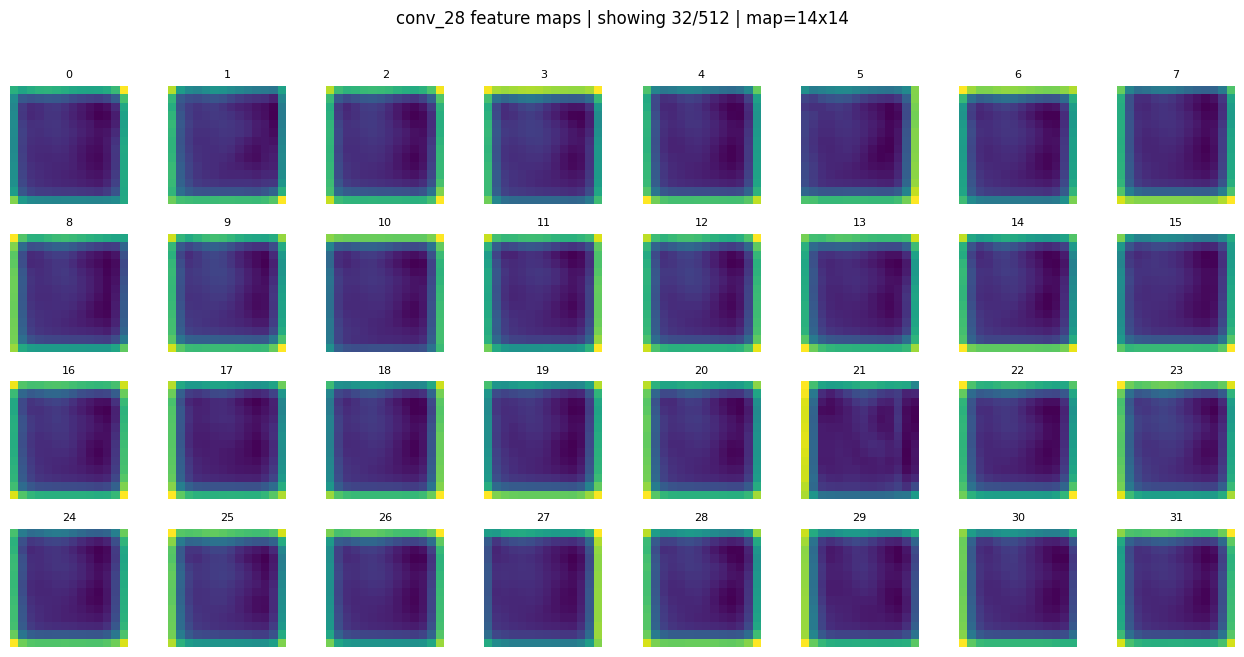

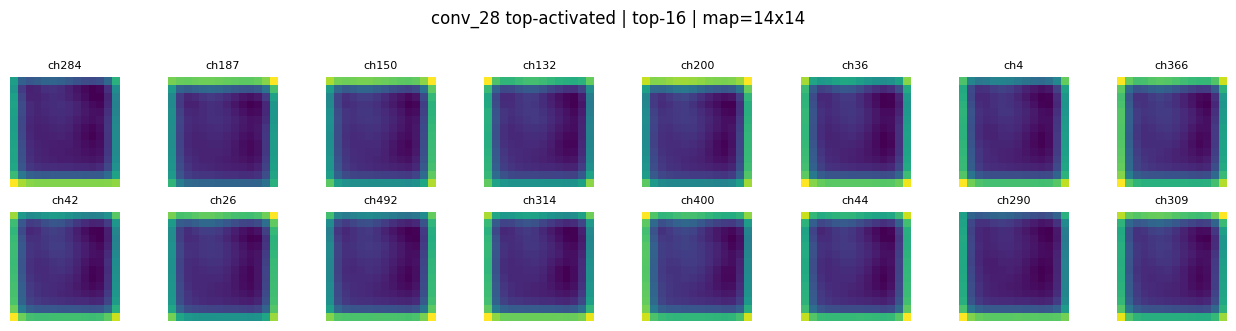

✅ Feature visualization complete


In [16]:

import numpy as np
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(4,4))
plt.imshow(denorm(x_img).permute(1,2,0))
plt.title(f"Input | true={class_names[int(y_lbl)]} | pred={class_names[pred]}")
plt.axis("off")
plt.show()

def show_feature_grid(feat, title, max_channels=32, ncols=8):
    feat = feat[0]  # (C,H,W)
    C, H, W = feat.shape
    n = min(C, max_channels)
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(1.6*ncols, 1.6*nrows))
    for i in range(n):
        ax = plt.subplot(nrows, ncols, i+1)
        fm = feat[i].numpy()
        fm = (fm - fm.min()) / (fm.max() - fm.min() + 1e-8)
        ax.imshow(fm)
        ax.set_title(str(i), fontsize=8)
        ax.axis("off")

    plt.suptitle(f"{title} | showing {n}/{C} | map={H}x{W}", y=1.02)
    plt.tight_layout()
    plt.show()

def show_top_activated(feat, title, topk=16, ncols=8):
    feat = feat[0]
    C, H, W = feat.shape
    scores = feat.abs().mean(dim=(1,2))
    top_idx = torch.topk(scores, k=min(topk, C)).indices.cpu().tolist()

    n = len(top_idx)
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(1.6*ncols, 1.6*nrows))
    for j, ch in enumerate(top_idx):
        ax = plt.subplot(nrows, ncols, j+1)
        fm = feat[ch].numpy()
        fm = (fm - fm.min()) / (fm.max() - fm.min() + 1e-8)
        ax.imshow(fm)
        ax.set_title(f"ch{ch}", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"{title} | top-{n} | map={H}x{W}", y=1.02)
    plt.tight_layout()
    plt.show()

for lname in list(acts.keys()):
    show_feature_grid(acts[lname], title=f"{lname} feature maps", max_channels=32, ncols=8)
    show_top_activated(acts[lname], title=f"{lname} top-activated", topk=16, ncols=8)

print("✅ Feature visualization complete")


## Step 16 — Visualize Conv1 filters *(What the first layer learns)*

First conv weight shape: (64, 3, 3, 3)


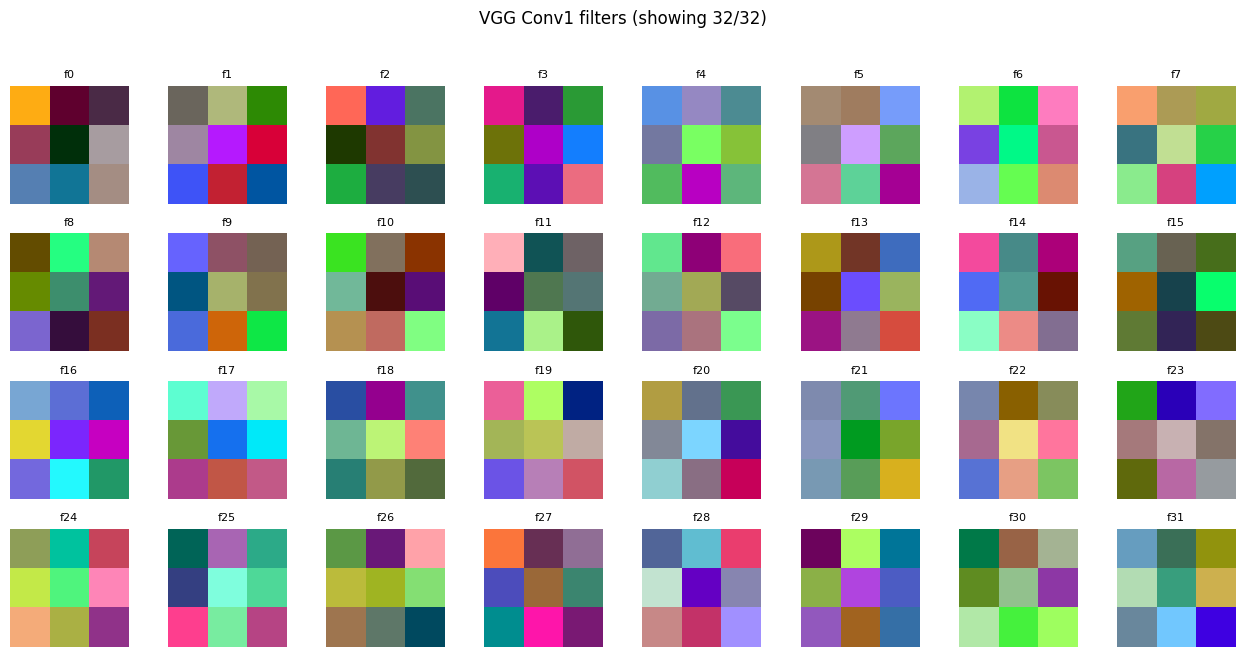

In [17]:

import numpy as np
import matplotlib.pyplot as plt
import torch

# Find first Conv2d in VGG features
first_conv = None
for m in model.features:
    if isinstance(m, nn.Conv2d):
        first_conv = m
        break

assert first_conv is not None, "Could not find Conv2d in VGG features."
W = first_conv.weight.detach().cpu()  # (out,3,k,k)

print("First conv weight shape:", tuple(W.shape))

def show_conv_filters(W, n_show=32, ncols=8):
    W = W[:n_show]
    n = W.shape[0]
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(1.6*ncols, 1.6*nrows))
    for i in range(n):
        w = W[i].clone()
        w = w - w.min()
        w = w / (w.max() + 1e-8)
        img = w.permute(1, 2, 0).numpy()

        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(img)
        ax.set_title(f"f{i}", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"VGG Conv1 filters (showing {n_show}/{W.shape[0]})", y=1.02)
    plt.tight_layout()
    plt.show()

show_conv_filters(W, n_show=32, ncols=8)


## Step 17 — Grad-CAM *(Where the model looked)*

✅ Removed activation hooks
✅ Grad-CAM | idx=0 | true=horse | pred=bird


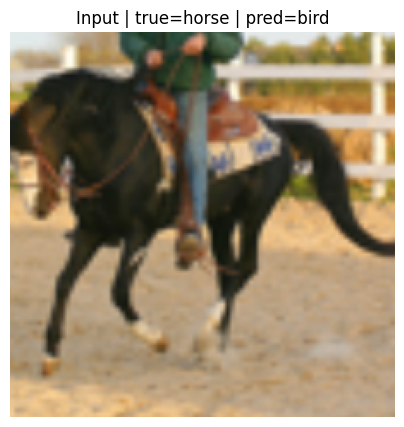

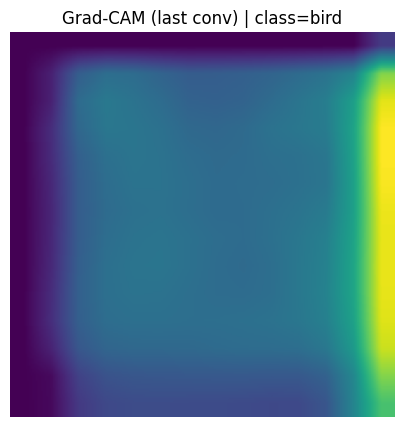

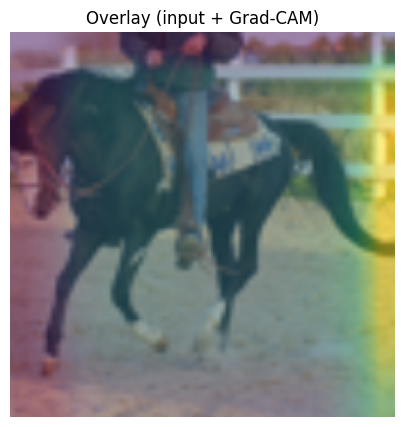

In [18]:

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Clean up hooks from Step 14
if "handles" in globals() and handles is not None:
    for h in handles:
        try: h.remove()
        except: pass
    handles = []
    print("✅ Removed activation hooks")

# Disable inplace ReLU for stability (VGG uses inplace=True by default)
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m.inplace = False

# Target layer: last Conv2d in features
target_layer = None
for m in reversed(list(model.features)):
    if isinstance(m, nn.Conv2d):
        target_layer = m
        break
assert target_layer is not None, "Could not find target Conv2d for Grad-CAM"

gc = {"acts": None, "grads": None}

def fwd_hook(module, inp, out):
    gc["acts"] = out.clone()
    out.register_hook(lambda grad: gc.__setitem__("grads", grad))

handle = target_layer.register_forward_hook(fwd_hook)

idx_cam = 0
x_img_cam, y_lbl_cam = test_ds[idx_cam]
x_in_cam = x_img_cam.unsqueeze(0).to(device)

model.eval()
model.zero_grad(set_to_none=True)

logits = model(x_in_cam)
pred_class = int(logits.argmax(dim=1).detach().cpu())

class_to_explain = pred_class  # or int(y_lbl_cam)
score = logits[0, class_to_explain]
score.backward()

handle.remove()

acts = gc["acts"]
grads = gc["grads"]
assert acts is not None and grads is not None, "Grad-CAM failed to capture activations/gradients."

weights = grads.mean(dim=(2,3), keepdim=True)
cam = (weights * acts).sum(dim=1, keepdim=True)
cam = F.relu(cam)

cam_up = F.interpolate(cam, size=(CFG["img_size"], CFG["img_size"]),
                       mode="bilinear", align_corners=False)
cam_up = cam_up[0, 0].detach().cpu().numpy()
cam_up = (cam_up - cam_up.min()) / (cam_up.max() - cam_up.min() + 1e-8)

img_vis = denorm(x_img_cam).permute(1, 2, 0).numpy()

print(f"✅ Grad-CAM | idx={idx_cam} | true={class_names[int(y_lbl_cam)]} | pred={class_names[pred_class]}")

plt.figure(figsize=(5,5))
plt.imshow(img_vis); plt.axis("off")
plt.title(f"Input | true={class_names[int(y_lbl_cam)]} | pred={class_names[pred_class]}")
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(cam_up); plt.axis("off")
plt.title(f"Grad-CAM (last conv) | class={class_names[class_to_explain]}")
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(img_vis)
plt.imshow(cam_up, alpha=0.45)
plt.axis("off")
plt.title("Overlay (input + Grad-CAM)")
plt.show()


## Step 18 — Inference utilities + export *(Single image, batch, inference-only checkpoint)*

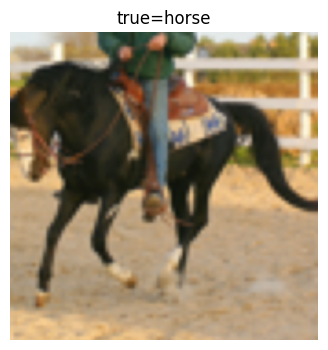

Predictions for test_ds[0]:
        bird  prob=0.1067
         cat  prob=0.1049
      monkey  prob=0.1023
    airplane  prob=0.1020
         dog  prob=0.1008
First 16 samples:
00: true=     horse | pred=      bird
01: true=    monkey | pred=      bird
02: true=       dog | pred=      bird
03: true=  airplane | pred=      bird
04: true=       cat | pred=      bird
05: true=      bird | pred=      bird
06: true=      bird | pred=      bird
07: true=      bird | pred=      bird
08: true=      deer | pred=      bird
09: true=      deer | pred=      bird
10: true=  airplane | pred=      bird
11: true=  airplane | pred=      bird
12: true=      deer | pred=      bird
13: true=  airplane | pred=      bird
14: true=      bird | pred=      bird
15: true=       dog | pred=      bird
✅ Saved inference-only checkpoint: vgg16_stl10_runs\vgg16_stl10_v1\checkpoints\vgg16_stl10_infer_only.pt


In [19]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

@torch.no_grad()
def predict_one(idx=0, topk=5):
    model.eval()
    x_img, y_lbl = test_ds[idx]
    x_in = x_img.unsqueeze(0).to(device)

    logits = model(x_in)
    probs = F.softmax(logits, dim=1)[0].detach().cpu()
    top_p, top_i = torch.topk(probs, k=min(topk, probs.numel()))

    plt.figure(figsize=(4,4))
    plt.imshow(denorm(x_img).permute(1,2,0))
    plt.axis("off")
    plt.title(f"true={class_names[int(y_lbl)]}")
    plt.show()

    print(f"Predictions for test_ds[{idx}]:")
    for p, i in zip(top_p.tolist(), top_i.tolist()):
        print(f"  {class_names[i]:>10s}  prob={p:.4f}")

@torch.no_grad()
def predict_batch(n_show=16):
    model.eval()
    xb, yb = next(iter(test_loader))
    xb = xb.to(device, non_blocking=True)
    logits = model(xb)
    pred = logits.argmax(dim=1).detach().cpu()

    n_show = min(n_show, len(yb))
    print("First", n_show, "samples:")
    for i in range(n_show):
        t = int(yb[i]); p = int(pred[i])
        print(f"{i:02d}: true={class_names[t]:>10s} | pred={class_names[p]:>10s}")

# Demo
predict_one(idx=0, topk=5)
predict_batch(n_show=16)

# Export inference-only checkpoint
infer_path = ckpt_dir / "vgg16_stl10_infer_only.pt"
torch.save({
    "cfg": CFG,
    "class_names": class_names,
    "model_state": model.state_dict()
}, str(infer_path))

print("✅ Saved inference-only checkpoint:", infer_path)
